# Trends in Anti-Social Behaviour Crime Statistics in England and Wales

This analysis was completed as my final project for the **Professional Certificate in Data Analysis** from **Imperial College Business School**.</br>

I use crime data published by the police combined with other datasets to identify trends around which areas of England & Wales have higher or lower levels of Anti-Social Behaviour.

## Data Sources 
Contains public sector information and data from the Office for National Statistics, both licensed under the Open Government Licence v.1.0.
* [Crime Statistics](https://data.police.uk/data/) from the UK Police
* [UK Census figures: age, education, unemployment, heating and tenure](https://www.nomisweb.co.uk/census/2021/data_finder) from the Office for National Statistics
* [Business Register and Employment Survey](https://www.nomisweb.co.uk/datasets/newbres6pub) from the Office for National Statistics
* [Lookup file for LSOAs 2011 to LSOAs 2021](https://www.data.gov.uk/dataset/b82d9b7d-7626-4aa1-9973-c6b19836c26b/lsoa-2011-to-lsoa-2021-to-local-authority-district-2022-best-fit-lookup-for-ew) from the Office for National Statistics

## Contents
* [Importing Libraries](#import_libs)
* [Importing Data Sources](#import_data)
    * [Crime](#import_crime)
    * [Census: age, education, unemployment, heating and tenure](#import_census)
    * [Employees in Retail and Entertainment](#import_employees)
* [Merging](#merging)
* [Data Exploration](#explore)
* [Modelling a Machine Learning Model](#model)


## Importing Libraries <a id="import_libs"></a>

In [55]:
import numpy as np
import pandas as pd
import datetime as dt
from scipy.stats import kurtosis, skew
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import glob

## Importing Data Sources <a id="import_data"></a>

### Crime  <a id="import_crime"></a>

The crime data is published in 42 separate monthly files, one for each of the 43 territorial police districts in England & Wales minus Greater Manchester Police.</br>
Therefore we will work with 12 x 42 = 504 files covering October 2023 to September 2024: the most recent 12 months.</br>
There will be enough data without Greater Manchester Police, 42 of the 43 police territories are sufficient for our purposes.</br>
We will later summarise what proportion of the England & Wales Anti Social Behaviour crimes data is in scope.</br>

In [56]:
# Import a sample crime file and explore data structure
sample_crime = pd.read_csv("Crime_Data/2024-09-Essex-Street.csv")
print(sample_crime.shape)
sample_crime.head()

(12226, 12)


,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context
0,4be24406a1ce6fd9639b3c9030b239f4e036d6f5baf214...,2024-09,Essex Police,Essex Police,0.971553,51.963597,On or near The Street,E01029905,Babergh 010G,Public order,Investigation complete; no suspect identified,NaN
1,d2765599d6bab305424c7f00b1ad828bbdd4a76269b8e9...,2024-09,Essex Police,Essex Police,0.443234,51.639560,On or near Goatsmoor Lane,E01021237,Basildon 001A,Burglary,Under investigation,NaN
2,ccf6756160431b4cf6b719fea82a191e79bfe9210aebd0...,2024-09,Essex Police,Essex Police,0.439211,51.642710,On or near Potash Road,E01021237,Basildon 001A,Criminal damage and arson,Under investigation,NaN
3,6d3bb1782e0218e3b19e1b08d7a3c8759d63bfe58bf83a...,2024-09,Essex Police,Essex Police,0.432091,51.640106,On or near Oakwood Drive,E01021237,Basildon 001A,Violence and sexual offences,Under investigation,NaN
4,72bb771b20e649f37f226e73afb7ae90985cbea4d94ded...,2024-09,Essex Police,Essex Police,0.435943,51.643479,On or near Penwood Close,E01021238,Basildon 001B,Burglary,Under investigation,NaN


The 504 csv files are identical in structure: 12 columns and one row per crime (e.g. 10,000 to 50,000 rows).</br>
Each crime has an Lower Super Output Area (LSOA) code to indicate the area where it took place, and a crime type.</br>
We need to put all of the Anti-Social Behaviour crimes (filter by type) into one combined dataframe for the whole of England & Wales.</br>
We'll then summarise this into a count of ASB crimes by LSOA, one row per LSOA.

In [57]:
# cycle through the 504 csv files to create one combined dataframe of Anti-Social Behaviour offences
asb_2324_files = glob.glob("Crime_Data/20*.csv")
asb_2324_dfs = []
for filename in asb_2324_files:
    asb_2324_df = pd.read_csv(filename)
    asb_2324_df = asb_2324_df[asb_2324_df['Crime type'] == "Anti-social behaviour"]
    asb_2324_dfs.append(asb_2324_df)
asb_2324 = pd.concat(asb_2324_dfs)
asb_2324.head()

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context
1,NaN,2023-10,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.514370,51.409298,On or near Lays Drive,E01014399,Bath and North East Somerset 001A,Anti-social behaviour,NaN,NaN
2,NaN,2023-10,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.509285,51.409716,On or near Barnard Walk,E01014399,Bath and North East Somerset 001A,Anti-social behaviour,NaN,NaN
3,NaN,2023-10,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.492876,51.422716,On or near Trajectus Way,E01014399,Bath and North East Somerset 001A,Anti-social behaviour,NaN,NaN
4,NaN,2023-10,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.492876,51.422716,On or near Trajectus Way,E01014399,Bath and North East Somerset 001A,Anti-social behaviour,NaN,NaN
5,NaN,2023-10,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.509285,51.409716,On or near Barnard Walk,E01014399,Bath and North East Somerset 001A,Anti-social behaviour,NaN,NaN


In [58]:
asb_2324.info()

<class 'pandas.core.frame.DataFrame'>
Index: 892684 entries, 1 to 4083
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Crime ID               0 non-null       object 
 1   Month                  892684 non-null  object 
 2   Reported by            892684 non-null  object 
 3   Falls within           892684 non-null  object 
 4   Longitude              891236 non-null  float64
 5   Latitude               891236 non-null  float64
 6   Location               892684 non-null  object 
 7   LSOA code              891235 non-null  object 
 8   LSOA name              891235 non-null  object 
 9   Crime type             892684 non-null  object 
 10  Last outcome category  0 non-null       object 
 11  Context                0 non-null       float64
dtypes: float64(3), object(9)
memory usage: 88.5+ MB


In [59]:
# proporion of crimes where LSOA code is missing
asb_2324['LSOA code'].count() / asb_2324.shape[0]

0.9983768052300702

Whilst there are some crimes for which LSOA code is missing, these represent 0.16% of the crimes</br>
We can look at them to see whether there is any structure to which ones are missing</br>

In [60]:
# inspect rows with missing LSOA code
asb_2324[asb_2324['LSOA code'].isnull()]

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context
5052,NaN,2023-10,Bedfordshire Police,Bedfordshire Police,NaN,NaN,No Location,NaN,NaN,Anti-social behaviour,NaN,NaN
6802,NaN,2023-10,Cambridgeshire Constabulary,Cambridgeshire Constabulary,NaN,NaN,No Location,NaN,NaN,Anti-social behaviour,NaN,NaN
6803,NaN,2023-10,Cambridgeshire Constabulary,Cambridgeshire Constabulary,NaN,NaN,No Location,NaN,NaN,Anti-social behaviour,NaN,NaN
6804,NaN,2023-10,Cambridgeshire Constabulary,Cambridgeshire Constabulary,NaN,NaN,No Location,NaN,NaN,Anti-social behaviour,NaN,NaN
6805,NaN,2023-10,Cambridgeshire Constabulary,Cambridgeshire Constabulary,NaN,NaN,No Location,NaN,NaN,Anti-social behaviour,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
25214,NaN,2024-09,West Yorkshire Police,West Yorkshire Police,NaN,NaN,No Location,NaN,NaN,Anti-social behaviour,NaN,NaN
25215,NaN,2024-09,West Yorkshire Police,West Yorkshire Police,NaN,NaN,No Location,NaN,NaN,Anti-social behaviour,NaN,NaN
25216,NaN,2024-09,West Yorkshire Police,West Yorkshire Police,NaN,NaN,No Location,NaN,NaN,Anti-social behaviour,NaN,NaN
25217,NaN,2024-09,West Yorkshire Police,West Yorkshire Police,NaN,NaN,No Location,NaN,NaN,Anti-social behaviour,NaN,NaN


In [61]:
# are the crimes with missing LSOAs typically from one police region?
asb_2324[asb_2324['LSOA code'].isnull()]['Falls within'].value_counts()

Falls within
South Wales Police              456
Thames Valley Police            290
West Yorkshire Police           269
North Yorkshire Police          199
Sussex Police                    63
City of London Police            53
Cambridgeshire Constabulary      32
West Mercia Police               23
Gloucestershire Constabulary     22
Bedfordshire Police              11
North Wales Police                9
Durham Constabulary               7
Gwent Police                      6
South Yorkshire Police            2
Kent Police                       2
Suffolk Constabulary              2
Norfolk Constabulary              1
Lancashire Constabulary           1
Warwickshire Police               1
Name: count, dtype: int64

The 1449 crimes with missing LSOAs are from a variety of police districts.</br>
We could fill each one by using the mode (most common) LSOA code for that police district.</br>
However, with only 0.16% of the rows having missing LSOAs, it's perfectly valid to just drop these, since the 99.8% of data which is complete will give us a valid dataset from which to draw conclusions.</br>
We will go ahead and make a dataframe with an ASB count, one row per LSOA</br>

In [62]:
lsoa_asb_2324 = asb_2324['LSOA code'].value_counts().to_frame().reset_index()
lsoa_asb_2324.rename(columns={'LSOA code': 'lsoa', 'count': 'asb_2324'}, inplace=True) 
lsoa_asb_2324.head()

,lsoa,asb_2324
0,E01002444,1220
1,E01033543,1091
2,E01035716,885
3,E01008397,779
4,E01012736,753


In [63]:
lsoa_asb_2324.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33691 entries, 0 to 33690
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   lsoa      33691 non-null  object
 1   asb_2324  33691 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 526.6+ KB


Note that not every LSOA in England and Wales had an ASB crime in October 2023 to September 2024.</br>
Due to how we've compiled the data, it's logical that any LSOAs without any ASB crime will not be in the dataframe at this stage.</br>
Therefore on merging later, we can fill this missing data with 0.

### Census <a id="import_census"></a>

The UK census from 2021 contains many datasets which may relate to anti-social behaviour, all available as tidy csv files with one row per LSOA.</br>
Of these, we will look at: age, education, unemployment, central heating, and tenure.</br>
Note that:</br>
* The census took place during the pandemic, which may effect some figures particularly unemployment
* These figures will relate to households in the location of the crime, which may not be where the victim or perpetrator reside


#### Age Breakdown

In [64]:
# import csv without intro
age = pd.read_csv('data/age.csv', skiprows=5, nrows = 35672)

# check top and bottom
# print(age.head())
# print(age.tail())

# lsoa is in one field for code and name: split into separate fields
age[['lsoa', 'lsoa_name']] = age['2021 super output area - lower layer'].str.split(' : ', expand=True)

age.describe()

,Total,Aged 4 years and under,Aged 5 to 9 years,Aged 10 to 15 years,Aged 16 to 19 years,Aged 20 to 24 years,Aged 25 to 34 years,Aged 35 to 49 years,Aged 50 to 64 years,Aged 65 to 74 years,Aged 75 to 84 years,Aged 85 years and over
count,35672.0,35672.000000,35672.000000,35672.000000,35672.000000,35672.000000,35672.000000,35672.000000,35672.000000,35672.000000,35672.000000,35672.000000
mean,100.0,5.352203,5.863557,7.130629,4.394904,5.865087,13.346633,19.235302,19.751455,10.197410,6.360709,2.501592
std,0.0,1.777776,1.713465,2.031375,2.589675,4.553600,5.496533,3.512529,4.226083,4.167411,3.294463,1.641664
min,100.0,0.100000,0.100000,0.000000,0.200000,1.000000,2.300000,2.000000,0.100000,0.100000,0.000000,0.000000
25%,100.0,4.100000,4.800000,5.900000,3.400000,4.100000,9.800000,17.000000,17.400000,7.100000,3.800000,1.300000
50%,100.0,5.200000,5.800000,7.000000,4.100000,5.000000,12.600000,19.100000,20.100000,10.000000,6.000000,2.200000
75%,100.0,6.400000,6.900000,8.300000,4.800000,6.100000,15.500000,21.400000,22.500000,13.000000,8.500000,3.300000
max,100.0,18.800000,19.800000,24.500000,60.300000,76.100000,65.200000,36.300000,33.400000,29.900000,26.800000,19.100000


In [65]:
# We probably want to combine these and only work with a couple of categories, but hard to know which grouping would be most relevant
# Will take it all forward for merging as it is, then correlate with crime and see if any further feature engineering is required

# make column names shorter
age.columns = age.columns.map(lambda x: x.lower().strip())

# Remove unwanted columns
age = age.drop(['lsoa_name', '2021 super output area - lower layer', 'total'], axis=1)

# check it's ready to merge
age.head()

,aged 4 years and under,aged 5 to 9 years,aged 10 to 15 years,aged 16 to 19 years,aged 20 to 24 years,aged 25 to 34 years,aged 35 to 49 years,aged 50 to 64 years,aged 65 to 74 years,aged 75 to 84 years,aged 85 years and over,lsoa
0,7.3,7.4,8.4,4.4,6.3,14.2,17.3,20.6,8.1,4.1,1.8,E01011954
1,4.5,4.0,5.9,3.3,4.7,8.5,14.3,23.3,16.5,10.9,3.9,E01011969
2,3.8,3.9,4.5,2.8,5.0,11.3,14.1,25.2,19.6,8.3,1.4,E01011970
3,3.6,5.5,9.3,5.1,7.9,10.0,20.5,26.0,8.1,3.3,0.8,E01011971
4,5.2,7.8,10.8,5.5,4.2,11.9,26.6,18.1,5.7,3.3,0.9,E01033465


#### Education

In [66]:
# import csv without intro and footer
education = pd.read_csv('data/education.csv', skiprows=7, nrows = 35672)

# check top and bottom
# print(education.head())
# print(education.tail())

# lsoa is in one field for code and name: split into separate fields
education[['lsoa', 'lsoa_name']] = education['2021 super output area - lower layer'].str.split(' : ', expand=True)

education.describe()

,Total: All usual residents aged 16 years and over,No qualifications,Level 1 and entry level qualifications,Level 2 qualifications,Apprenticeship,Level 3 qualifications,Level 4 qualifications or above,Other qualifications
count,35672.0,35672.000000,35672.000000,35672.000000,35672.000000,35672.000000,35672.000000,35672.000000
mean,100.0,18.393687,9.750460,13.506386,5.409770,16.691217,33.500272,2.748523
std,0.0,7.223700,2.784813,2.946054,1.912892,4.742714,12.614185,0.927340
min,100.0,0.800000,0.200000,0.900000,0.100000,4.200000,9.000000,0.100000
25%,100.0,13.100000,8.100000,12.100000,4.200000,14.400000,23.900000,2.100000
50%,100.0,17.700000,9.900000,13.900000,5.500000,16.400000,31.400000,2.700000
75%,100.0,23.100000,11.700000,15.400000,6.700000,18.300000,40.600000,3.200000
max,100.0,51.600000,22.600000,31.600000,20.700000,78.700000,87.200000,12.900000


In [67]:
# just take lsoa and low education (households with max education level 2) forward for the merge

education['educated_level2max_perc'] = education['No qualifications'] + education['Level 1 and entry level qualifications'] + education['Level 2 qualifications']
education = education[['lsoa', 'educated_level2max_perc']]

# check it's ready to merge
education.head()


,lsoa,educated_level2max_perc
0,E01011954,50.8
1,E01011969,43.4
2,E01011970,38.5
3,E01011971,33.8
4,E01033465,33.0


#### Unemployment

In [68]:
# import csv without intro and footer
unemployment = pd.read_csv('data/unemployment.csv', skiprows=7, nrows = 35672)

# check top and bottom
# print(unemployment.head())
# print(unemployment.tail())

# lsoa is in one field for code and name: split into separate fields
unemployment[['lsoa', 'lsoa_name']] = unemployment['2021 super output area - lower layer'].str.split(' : ', expand=True)

unemployment.describe()

,Total: All usual residents aged 16 years and over,Economically active (excluding full-time students): Unemployed
count,35672.0,35672.000000
mean,100.0,2.838711
std,0.0,1.446767
min,100.0,0.000000
25%,100.0,1.800000
50%,100.0,2.500000
75%,100.0,3.600000
max,100.0,15.600000


In [69]:
# just take lsoa and our new feature for the merge
unemployment = unemployment[['lsoa', 'Economically active (excluding full-time students): Unemployed']]
unemployment.columns = ['lsoa', 'unemployed_perc']

# check it's ready to merge
unemployment.head()

,lsoa,unemployed_perc
0,E01011954,3.8
1,E01011969,3.0
2,E01011970,1.4
3,E01011971,1.7
4,E01033465,2.0


#### Central Heating

In [70]:
# % of households without central heating is sometimes used as a proxy for deprivation

# import csv without intro and footer
heating = pd.read_csv('data/heating.csv', skiprows=7, nrows = 35672)

# check top and bottom
# print(heating.head())
# print(heating.tail())

# lsoa is in one field for code and name: split into separate fields
heating[['lsoa', 'lsoa_name']] = heating['2021 super output area - lower layer'].str.split(' : ', expand=True)

heating.describe()

,Total: All households,No central heating
count,35672.0,35672.000000
mean,100.0,1.456164
std,0.0,1.066794
min,100.0,0.000000
25%,100.0,0.700000
50%,100.0,1.200000
75%,100.0,1.900000
max,100.0,17.500000


In [71]:
# there is very little variation in these figures, but it's a well-known proxy so I'll take it forwards.

# just take lsoa and our new feature for the merge
heating = heating[['lsoa', 'No central heating']]
heating.columns = ['lsoa', 'home_no_heating_perc']

# check it's ready to merge
heating.head()

,lsoa,home_no_heating_perc
0,E01011954,0.6
1,E01011969,0.8
2,E01011970,2.1
3,E01011971,0.0
4,E01033465,0.0


#### Tenure

In [72]:
# % of households with various types of ownerships

# import csv without intro and footer
tenure = pd.read_csv('data/tenure.csv', skiprows=7, nrows = 35672)

# check top and bottom
# print(tenure.head())
# print(tenure.tail())

# lsoa is in one field for code and name: split into separate fields
tenure[['lsoa', 'lsoa_name']] = tenure['2021 super output area - lower layer'].str.split(' : ', expand=True)

tenure.describe()

,Total: All households,Owned,Shared ownership,Social rented,Private rented,Lives rent free
count,35672.0,35672.000000,35672.000000,35672.000000,35672.000000,35672.000000
mean,100.0,62.224972,0.929012,16.906162,19.808898,0.131680
std,0.0,20.547570,1.615214,15.997501,12.787978,0.258551
min,100.0,2.000000,0.000000,0.000000,1.700000,0.000000
25%,100.0,47.500000,0.200000,4.600000,10.900000,0.000000
50%,100.0,65.700000,0.400000,11.400000,15.700000,0.000000
75%,100.0,79.200000,1.000000,24.900000,25.000000,0.200000
max,100.0,97.900000,33.900000,92.000000,93.000000,7.800000


In [73]:
# I'm not clear which of these will be most helpful, I think I'll just take rented (private + social) and owned forward
# 'Shared ownership' and 'lives rent free' will be ommitted

# create single feature for rented
tenure['rented'] = tenure['Private rented'] + tenure['Social rented']

# just take lsoa, owned and rented foward
tenure = tenure[['lsoa', 'Owned', 'rented']]
tenure.columns = ['lsoa', 'homes_owned_perc', 'homes_rented_perc']

# check it's ready
tenure.head()

# note that as homes_owned_perc increases, homes_rented_perc decreases and vice versa - they are correlated
# therefore we would only use one of these for a machine learning model, but will look at both in our data exploration

,lsoa,homes_owned_perc,homes_rented_perc
0,E01011954,55.6,44.2
1,E01011969,84.5,15.5
2,E01011970,90.3,9.4
3,E01011971,87.5,11.7
4,E01033465,78.9,21.1


### Employees in Retail and Arts <a id="import_employees"></a>

The census tells us about the resident population of an LSOA, but people don't necessarily commit ASB in their own neighbourhood.</br>
We also need some statistics about the area itself, aside from the residents who live there.</br>
It may be that city centre locations with a lot of pubs, shops etc. have a different level of ASB compared to areas without these ammenities.</br>
The number of employees in these industries ('Retail', and 'Arts, entertainment, recreation & other services') in these locations will be used as the metric.</br>
This file is from 2022 but uses older LSOA definitions, so has a different number of LSOAs compared to the census data.</br>
The discrepancy between LSOA boundaries is addressed before the merge.</br>

In [74]:
# import csv without intro and footer
employees = pd.read_csv('data/Employee_Industries.csv', skiprows=8, nrows = 34753)
employees.head()

# check top and bottom
# print(employees.head())
# print(employees.tail())

# lsoa is in one field for code and name: split into separate fields
employees[['lsoa', 'lsoa_name']] = employees['2011 super output area - lower layer'].str.split(' : ', expand=True)

employees.describe()

,7 : Retail (Part G),Unnamed: 2,"18 : Arts, entertainment, recreation & other services (R,S,T and U)",2
count,34753.000000,0.0,34753.000000,0.0
mean,69.283227,NaN,35.477369,NaN
std,229.474077,NaN,127.335246,NaN
min,0.000000,NaN,0.000000,NaN
25%,5.000000,NaN,0.000000,NaN
50%,20.000000,NaN,10.000000,NaN
75%,50.000000,NaN,30.000000,NaN
max,12000.000000,NaN,7000.000000,NaN


In [75]:
# combine retail and entertainment into one feature
employees['retail_entertainment_workers'] = employees['7 : Retail (Part G)'] + employees['18 : Arts, entertainment, recreation & other services (R,S,T and U)']

# remove the blank and redundant columns
employees = employees.drop(['2011 super output area - lower layer', 'Unnamed: 2', '2', 'lsoa_name', '7 : Retail (Part G)', '18 : Arts, entertainment, recreation & other services (R,S,T and U)'], axis = 1)

# check it's ready to merge
employees.head()

,lsoa,retail_entertainment_workers
0,E01000001,775
1,E01000002,1700
2,E01000003,75
3,E01000005,525
4,E01000006,5


In [76]:
employees.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34753 entries, 0 to 34752
Data columns (total 2 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   lsoa                          34753 non-null  object
 1   retail_entertainment_workers  34753 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 543.1+ KB


Employees file now ready for merging

## Merging <a id="merging"></a>

### Prepare for Merging

We're going to merge on LSOA, however, one of our data sources (retails and entertainment sector employees) uses 2011 LSOAs, and the others (Crime, Census) use 2021 LSOAs.  That is: the LSOA boundaries are tweaked slightly every ten years, so our data sources don't match.</br>
We need to identify how significant the changes were, using a gov.uk spreadsheet which highlights the changes.

In [77]:
lsoa = pd.read_csv('data/LSOA_lookup.csv')
lsoa.head()

,LSOA11CD,LSOA11NM,LSOA21CD,LSOA21NM,CHGIND,LAD22CD,LAD22NM,LAD22NMW,ObjectId
0,E01031349,Adur 001A,E01031349,Adur 001A,U,E07000223,Adur,NaN,1
1,E01031350,Adur 001B,E01031350,Adur 001B,U,E07000223,Adur,NaN,2
2,E01031351,Adur 001C,E01031351,Adur 001C,U,E07000223,Adur,NaN,3
3,E01031352,Adur 001D,E01031352,Adur 001D,U,E07000223,Adur,NaN,4
4,E01031370,Adur 001E,E01031370,Adur 001E,U,E07000223,Adur,NaN,5


In [78]:
# What proportion of LSOAs have "U" for unchanged in the CHGIND column?
lsoa['CHGIND'].value_counts(normalize = True)

CHGIND
U    0.939965
S    0.053079
M    0.006677
X    0.000279
Name: proportion, dtype: float64

Since 94% of the LSOAs have unchanged boundaries between 2011 and 2021, we will use these unchanged LSOAs only, and discard the other LSOAs

In [79]:
# Create new Dataframe with just these unchanged LSOAs, ready for merging in all the relevant data
df = lsoa[lsoa['CHGIND'] == "U"]

# Check that every LSOA has the same code for 2011 and 2021 (i.e. LSOA11CD matches LSOA21CD)
df['LSOA11CD'].equals(df['LSOA21CD'])


True

In [80]:
# Unfortunately the crime data is missing for the Greater Manchester Constabulary
# Therefore, we need to exclude LSOAs in Bolton, Bury, Manchester, Oldham, Rochdale, Salford, Stockport, Tameside, Trafford and Wigan

greater_manc_authorities_to_drop = ['Bolton', 'Bury', 'Manchester', 'Oldham', 'Rochdale', 'Salford', 'Stockport', 'Tameside', 'Trafford', 'Wigan']

df = df[~df['LAD22NM'].isin(greater_manc_authorities_to_drop)]

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32011 entries, 0 to 35795
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   LSOA11CD  32011 non-null  object
 1   LSOA11NM  32011 non-null  object
 2   LSOA21CD  32011 non-null  object
 3   LSOA21NM  32011 non-null  object
 4   CHGIND    32011 non-null  object
 5   LAD22CD   32011 non-null  object
 6   LAD22NM   32011 non-null  object
 7   LAD22NMW  1837 non-null   object
 8   ObjectId  32011 non-null  int64 
dtypes: int64(1), object(8)
memory usage: 2.4+ MB


In [81]:
# We've deleted the LSOAs with changed boundaries, and the ones from Greater Manchester
# Check that the remaining LSOAs are sufficient for the exercise to be meaningful

all_england_wales_lsoas = 35672
final_lsoas = df.shape[0]

final_lsoas / all_england_wales_lsoas

# 90% is still ok

0.8973704866562009

In [82]:
# prepare the df for merging in
df = df.drop(['LSOA21CD', 'LSOA11NM', 'LAD22CD', 'CHGIND', 'LAD22NMW', 'ObjectId'], axis = 1)
df.columns=['lsoa', 'name', 'authority_name']

df.head()

,lsoa,name,authority_name
0,E01031349,Adur 001A,Adur
1,E01031350,Adur 001B,Adur
2,E01031351,Adur 001C,Adur
3,E01031352,Adur 001D,Adur
4,E01031370,Adur 001E,Adur


In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32011 entries, 0 to 35795
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   lsoa            32011 non-null  object
 1   name            32011 non-null  object
 2   authority_name  32011 non-null  object
dtypes: object(3)
memory usage: 1000.3+ KB


### Merging

In [84]:
# merge in the ASB September 2024 figure
df = df.merge(lsoa_asb_2324, how = 'left')
df.head()

,lsoa,name,authority_name,asb_2324
0,E01031349,Adur 001A,Adur,8.0
1,E01031350,Adur 001B,Adur,7.0
2,E01031351,Adur 001C,Adur,48.0
3,E01031352,Adur 001D,Adur,11.0
4,E01031370,Adur 001E,Adur,25.0


In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32011 entries, 0 to 32010
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   lsoa            32011 non-null  object 
 1   name            32011 non-null  object 
 2   authority_name  32011 non-null  object 
 3   asb_2324        31713 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1000.5+ KB


In [86]:
# the missing data for 300 of 32,000 LSOAs was anticipated due to how crime data was compiled - fill missing with 0
df['asb_2324'] = df['asb_2324'].fillna(value=0)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32011 entries, 0 to 32010
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   lsoa            32011 non-null  object 
 1   name            32011 non-null  object 
 2   authority_name  32011 non-null  object 
 3   asb_2324        32011 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1000.5+ KB


In [87]:
# export as csv for Tableau mapping excerise alongside LSOA shapefile from https://www.data.gov.uk/dataset/c481f2d3-91fc-4767-ae10-2efdf6d58996/lower-layer-super-output-areas-lsoas

df.to_csv('asb_lsoas.csv', index=False)

In [88]:
# merge all the other figures
sources = [df, age, education, unemployment, heating, tenure, employees]

for source in sources:
    df = df.merge(source, how='left')

df.head()

,lsoa,name,authority_name,asb_2324,aged 4 years and under,aged 5 to 9 years,aged 10 to 15 years,aged 16 to 19 years,aged 20 to 24 years,aged 25 to 34 years,...,aged 50 to 64 years,aged 65 to 74 years,aged 75 to 84 years,aged 85 years and over,educated_level2max_perc,unemployed_perc,home_no_heating_perc,homes_owned_perc,homes_rented_perc,retail_entertainment_workers
0,E01031349,Adur 001A,Adur,8.0,4.9,5.4,6.9,4.1,3.9,8.1,...,22.3,13.8,8.9,2.5,46.2,2.4,0.2,87.0,12.4,5
1,E01031350,Adur 001B,Adur,7.0,5.2,6.6,7.4,3.7,6.1,13.8,...,20.5,8.8,4.4,2.7,51.3,2.9,2.0,61.5,38.3,0
2,E01031351,Adur 001C,Adur,48.0,4.6,5.9,8.0,4.5,4.4,7.4,...,22.0,10.1,8.5,4.6,49.5,1.5,0.9,87.5,12.0,10
3,E01031352,Adur 001D,Adur,11.0,4.7,4.5,6.4,4.1,4.4,10.1,...,21.9,11.8,10.9,3.6,51.3,2.6,1.2,81.0,18.4,25
4,E01031370,Adur 001E,Adur,25.0,4.9,6.2,9.5,6.2,6.0,8.5,...,19.6,10.0,6.3,2.2,52.2,2.3,2.7,69.5,30.1,20


In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32011 entries, 0 to 32010
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   lsoa                          32011 non-null  object 
 1   name                          32011 non-null  object 
 2   authority_name                32011 non-null  object 
 3   asb_2324                      32011 non-null  float64
 4   aged 4 years and under        32011 non-null  float64
 5   aged 5 to 9 years             32011 non-null  float64
 6   aged 10 to 15 years           32011 non-null  float64
 7   aged 16 to 19 years           32011 non-null  float64
 8   aged 20 to 24 years           32011 non-null  float64
 9   aged 25 to 34 years           32011 non-null  float64
 10  aged 35 to 49 years           32011 non-null  float64
 11  aged 50 to 64 years           32011 non-null  float64
 12  aged 65 to 74 years           32011 non-null  float64
 13  a

Combined dataframe looks good, no missing data, all data types stored correctly

In [90]:
# check against an example LSOA
df[df.lsoa == 'E01013389']

# all perfect

,lsoa,name,authority_name,asb_2324,aged 4 years and under,aged 5 to 9 years,aged 10 to 15 years,aged 16 to 19 years,aged 20 to 24 years,aged 25 to 34 years,...,aged 50 to 64 years,aged 65 to 74 years,aged 75 to 84 years,aged 85 years and over,educated_level2max_perc,unemployed_perc,home_no_heating_perc,homes_owned_perc,homes_rented_perc,retail_entertainment_workers
31989,E01013389,York 008F,York,6.0,5.2,6.3,5.7,3.8,4.0,9.5,...,19.6,9.9,11.4,4.1,38.5,1.7,0.2,88.8,11.0,10


### Refining the Age Categories

In [91]:
# look at correlations to decide on most helpful age categories to take forward
crime_corr = df.corr(numeric_only=True)['asb_2324']
crime_corr.sort_values(ascending = False)

asb_2324                        1.000000
retail_entertainment_workers    0.489288
homes_rented_perc               0.445110
aged 25 to 34 years             0.366058
unemployed_perc                 0.329319
home_no_heating_perc            0.283530
aged 20 to 24 years             0.247512
aged 35 to 49 years             0.134648
aged 4 years and under          0.106769
aged 16 to 19 years             0.091540
educated_level2max_perc         0.016514
aged 5 to 9 years              -0.029676
aged 10 to 15 years            -0.096044
aged 85 years and over         -0.174596
aged 75 to 84 years            -0.266570
aged 50 to 64 years            -0.284717
aged 65 to 74 years            -0.295944
homes_owned_perc               -0.446488
Name: asb_2324, dtype: float64

In [92]:
# create single feature for % population aged 20 to 34 (positive correlation with ASB)
df['age_20_34'] = df['aged 20 to 24 years'] + df['aged 25 to 34 years']

# create single feature for % population aged 50 plus (negative correlation with ASB)
df['age_50_plus'] = df['aged 50 to 64 years'] + df['aged 65 to 74 years'] + df['aged 75 to 84 years'] +  df['aged 85 years and over']

# remove the original age categories
df = df.drop(['aged 4 years and under', 'aged 5 to 9 years',
       'aged 10 to 15 years', 'aged 16 to 19 years', 'aged 20 to 24 years',
       'aged 25 to 34 years', 'aged 35 to 49 years', 'aged 50 to 64 years',
       'aged 65 to 74 years', 'aged 75 to 84 years', 'aged 85 years and over'], axis=1)

# look at correlations again
crime_corr = df.corr(numeric_only=True)['asb_2324']
crime_corr.sort_values(ascending = False)

asb_2324                        1.000000
retail_entertainment_workers    0.489288
homes_rented_perc               0.445110
age_20_34                       0.379355
unemployed_perc                 0.329319
home_no_heating_perc            0.283530
educated_level2max_perc         0.016514
age_50_plus                    -0.308562
homes_owned_perc               -0.446488
Name: asb_2324, dtype: float64

## Data Exploration <a id="explore"></a>

Before investigating the ASB figures broken down by LSOA, we will first look at overall ASB.

### How much does ASB vary from Month to Month?

In [93]:
# get monthly counts from dataframe as new dataframe
monthly_asb_2324 = asb_2324['Month'].value_counts().to_frame().reset_index()
monthly_asb_2324

,Month,count
0,2024-07,90237
1,2024-08,89474
2,2024-05,87231
3,2024-06,84861
4,2023-10,77108
5,2024-04,73648
6,2024-09,72212
7,2024-03,72199
8,2024-02,65491
9,2023-11,64979


In [94]:
# create datetime column - sort by it, create more readable format for Month labels, drop and rename columns
monthly_asb_2324['date_time'] = pd.to_datetime(monthly_asb_2324['Month'])
monthly_asb_2324 = monthly_asb_2324.sort_values(by='date_time').reset_index(drop=True)
monthly_asb_2324['month'] = monthly_asb_2324['date_time'].dt.strftime("%B %y")
monthly_asb_2324.drop(['date_time', 'Month'], axis = 1, inplace = True)
monthly_asb_2324.columns = ['asb_count', 'month']

monthly_asb_2324

,asb_count,month
0,77108,October 23
1,64979,November 23
2,56266,December 23
3,58978,January 24
4,65491,February 24
5,72199,March 24
6,73648,April 24
7,87231,May 24
8,84861,June 24
9,90237,July 24


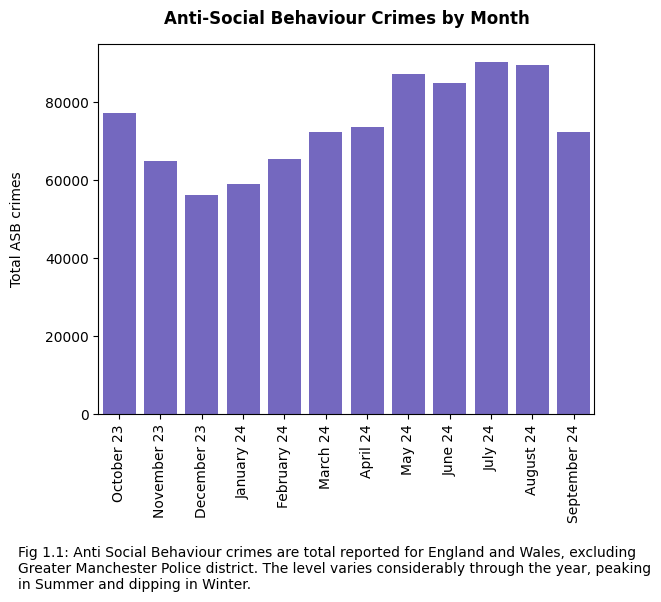

In [95]:
ax = sns.barplot(x = 'month', y = 'asb_count', color = 'slateblue', data = monthly_asb_2324)
plt.xticks(rotation= 90)
plt.xlabel("")
ax.set_title("Anti-Social Behaviour Crimes by Month", pad=15, fontweight="bold")
ax.set_ylabel("Total ASB crimes", labelpad=15)
txt="Fig 1.1: Anti Social Behaviour crimes are total reported for England and Wales, excluding Greater Manchester Police district. The level varies considerably through the year, peaking in Summer and dipping in Winter."
plt.figtext(0, -0.25, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.savefig('monthly_total_asb.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()


In [96]:
# Comparing month to month doesn't account for months being different lengths, so we'll look at average daily ASB to take this out
monthly_asb_2324['days_in_month'] = [31, 30, 31, 31, 29, 31, 30, 31, 30, 31, 31, 30]
monthly_asb_2324['ave_daily_asb'] = round(monthly_asb_2324['asb_count'] / monthly_asb_2324['days_in_month'],1)

# Also looks like there may be a relationship with season - perhaps long days keeping people outdoors
# Retrieved average daily light hours in London from https://www.worlddata.info/europe/united-kingdom/sunset.php
monthly_asb_2324['ave_daily_light_hours'] = [10.8, 8.9, 7.9, 8.4, 10.1, 11.9, 14.0, 15.7, 16.7, 16.2, 14.7, 12.7]

monthly_asb_2324

,asb_count,month,days_in_month,ave_daily_asb,ave_daily_light_hours
0,77108,October 23,31,2487.4,10.8
1,64979,November 23,30,2166.0,8.9
2,56266,December 23,31,1815.0,7.9
3,58978,January 24,31,1902.5,8.4
4,65491,February 24,29,2258.3,10.1
5,72199,March 24,31,2329.0,11.9
6,73648,April 24,30,2454.9,14.0
7,87231,May 24,31,2813.9,15.7
8,84861,June 24,30,2828.7,16.7
9,90237,July 24,31,2910.9,16.2


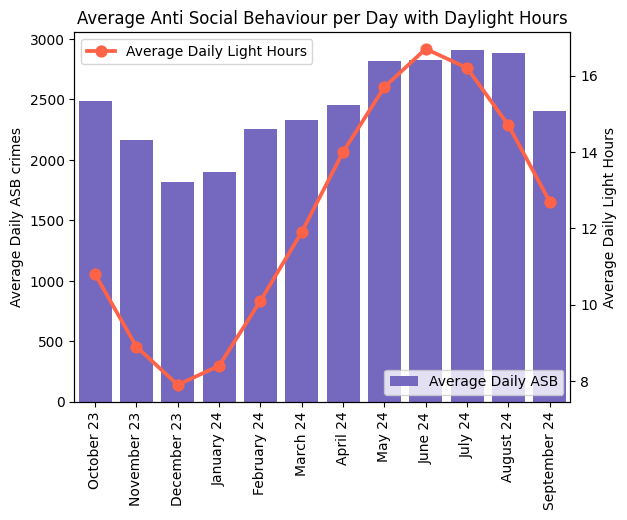

In [97]:
# plot average ASB and daylight hours on same chart

fig, ax1 = plt.subplots()
sns.barplot(x = 'month', y = 'ave_daily_asb', data = monthly_asb_2324, ax=ax1, color = 'slateblue', label = 'Average Daily ASB')
ax1.legend(loc=4)
plt.ylabel("Average Daily ASB crimes")
plt.xlabel("")
plt.xticks(rotation=90)
ax2 = ax1.twinx()
sns.pointplot(x = 'month', y = 'ave_daily_light_hours', data = monthly_asb_2324, color = 'tomato', ax=ax2, label = 'Average Daily Light Hours')
ax2.legend(loc=0)
plt.ylabel("Average Daily Light Hours")
plt.xlabel("")
plt.title("Average Anti Social Behaviour per Day with Daylight Hours")
plt.legend()
plt.show()
plt.close()

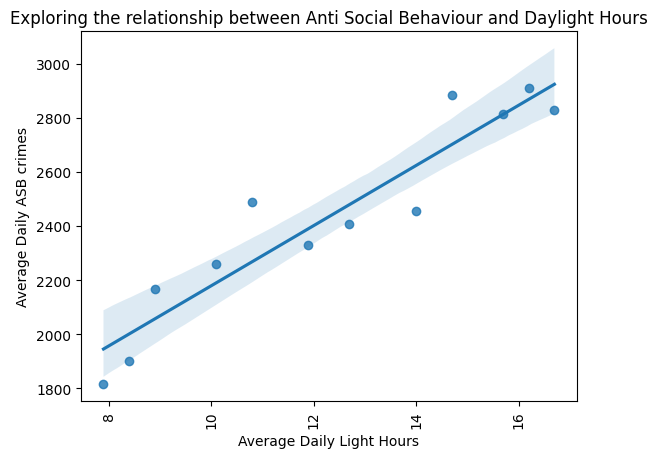

In [98]:
# Looks like a very clear relationship, we can possibly predict monthly ASB crimes with a simple linear equation
# Visually confirm linearity

sns.regplot(x = 'ave_daily_light_hours', y = 'ave_daily_asb', data = monthly_asb_2324)
plt.xticks(rotation= 90)
plt.ylabel("Average Daily ASB crimes")
plt.xlabel("Average Daily Light Hours")
plt.title("Exploring the relationship between Anti Social Behaviour and Daylight Hours")
plt.show()
plt.close()

In [99]:
# yes, looks pretty linear, so train a simple linear regression model
input_light = monthly_asb_2324.iloc[:, 4:]
output_asb = monthly_asb_2324.iloc[:, 3:4]

model = LinearRegression(fit_intercept=True)
model.fit(input_light,output_asb)

print(model.coef_)
print(model.intercept_)

# R squared accuracy score
model.score(input_light, output_asb)

[[111.2849009]]
[1065.81955558]


0.8851862816245412

This model is necessarily over-fit, we only have 12 months of data</br>
None-the-less, in this year of data, the number Anti Social Behaviour crimes can be predicted with 88.5% accuracy using this formula:</br>
Average Daily Anti Social Behaviour in any given month = (Average Daily Light Hours in Month * 111.283) + 1065.835

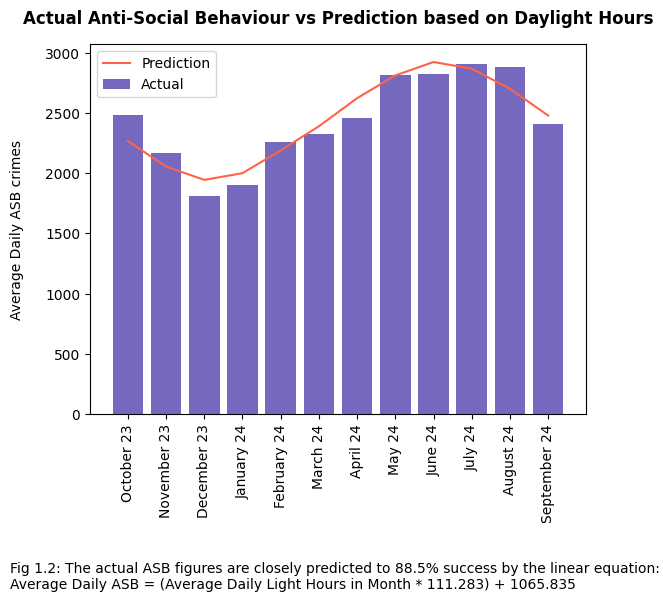

In [100]:
# Plot actuals and predictions on one plot

monthly_asb_2324['linear_predictions'] = model.predict(input_light)

fig, ax = plt.subplots()
sns.barplot(x = 'month', y = 'ave_daily_asb', data = monthly_asb_2324, color = 'slateblue', label = "Actual")
sns.lineplot(x = 'month', y = 'linear_predictions', data = monthly_asb_2324, color = 'tomato', label = "Prediction")
plt.xticks(rotation= 90)
ax.set_ylabel("Average Daily ASB crimes", labelpad=15)
plt.xlabel("")
txt="Fig 1.2: The actual ASB figures are closely predicted to 88.5% success by the linear equation: Average Daily ASB = (Average Daily Light Hours in Month * 111.283) + 1065.835"
plt.figtext(0, -0.25, txt, wrap=True, horizontalalignment='left', fontsize=10)
ax.set_title("Actual Anti-Social Behaviour vs Prediction based on Daylight Hours", pad=15, fontweight="bold")
plt.legend()
plt.savefig('monthly_ave_asb_vs_daylight_prediction.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()


This exercise has demonstrated that the number of Anti Social Crimes is relatively consistant, with almost all of the monthly variation accounted for by the number of daylight hours where people are likely to be outdoors.

### How much does ASB vary between different LSOAs?

We exported a csv several steps above and used this to create a map in Tableau which indicated that there is a great deal of variation from LSOA to LSOA, some of which may be related to urban vs rural areas.

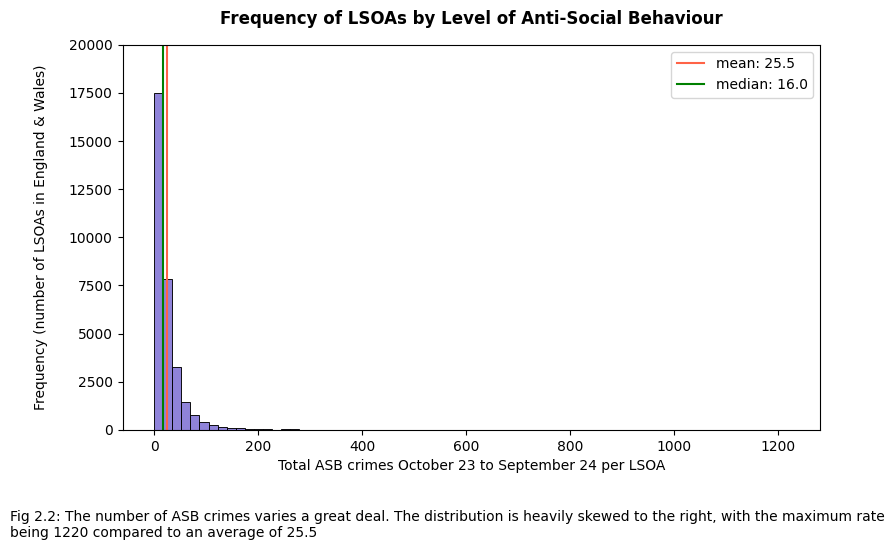

In [101]:
# histplot of asb figures
plt.figure(figsize = (9,5))
ax = sns.histplot(x = df.asb_2324, bins=70, color = 'slateblue')
plt.xlabel('Total ASB crimes October 23 to September 24 per LSOA')
ax.set_ylabel("Frequency (number of LSOAs in England & Wales)", labelpad=15)
ax.set_title("Frequency of LSOAs by Level of Anti-Social Behaviour", pad=15, fontweight="bold")
plt.axvline(x = df.asb_2324.mean(), color = 'tomato', label = f"mean: {round(df.asb_2324.mean(),1)}")
plt.axvline(x = df.asb_2324.median(), color = 'green', label = f"median: {round(df.asb_2324.median(),1)}")
plt.ylim(0,20000)
txt="Fig 2.2: The number of ASB crimes varies a great deal. The distribution is heavily skewed to the right, with the maximum rate being 1220 compared to an average of 25.5"
plt.figtext(0, -0.1, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.legend()
plt.savefig('hist_asb.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()


The mean is being pulled upwards due to the distribution being skewed to the right.  The median is 16 ASB crimes in an LSOA, and while it's only possible for an LSOA to have 16 fewer than that (no negative values) it's possible for an LSOA to have 1000 more than that, so the distribution is neer going to be normal.

In [102]:
# kurtosis and skewness
print(f"kurtosis is{kurtosis(df.asb_2324): .1f} where 3.0 would be a normal distribution and >3 is leptokurtic (more outliers)")
print(f"skewness is {skew(df.asb_2324): .1f} where 0.0 would be normal and >0 is right-tailed")

kurtosis is 122.6 where 3.0 would be a normal distribution and >3 is leptokurtic (more outliers)
skewness is  7.7 where 0.0 would be normal and >0 is right-tailed


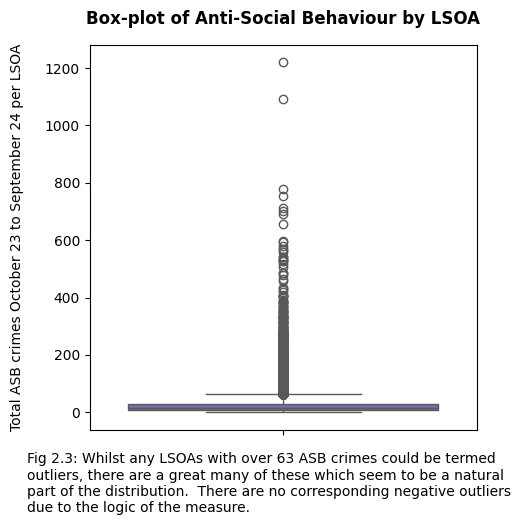

In [103]:
# boxplot of asb figures
plt.figure(figsize = (5,5))
ax = sns.boxplot(y = df.asb_2324, color = 'slateblue')
ax.set_ylabel("Total ASB crimes October 23 to September 24 per LSOA", labelpad=15)
ax.set_title("Box-plot of Anti-Social Behaviour by LSOA", pad=15, fontweight="bold")
txt="Fig 2.3: Whilst any LSOAs with over 63 ASB crimes could be termed outliers, there are a great many of these which seem to be a natural part of the distribution.  There are no corresponding negative outliers due to the logic of the measure."
plt.figtext(0, -0.05, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.savefig('box_asb.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

Whilst there are undoubtedly a high number of outliers, these seem to be a natural part of the data.</br>
Any value above 63 could be seen as an outlier due to being more than 1.5 * InterQuartile Range above the third quartile, but these appear to be part of how this real-life data is distributed.
Let's look at some of the highest LSOAs, including those top two, to see whether they appear to be incorrect or anomalous in some way.

#### LSOAs with highest ASB

In [104]:
# top ten LSOAs for highest level of ASB

topten = df.nlargest(10, "asb_2324").set_index("lsoa", drop=True)
means = round(df.describe().loc['mean'],1)
print(means)
topten

asb_2324                        25.5
educated_level2max_perc         41.9
unemployed_perc                  2.8
home_no_heating_perc             1.5
homes_owned_perc                62.9
homes_rented_perc               36.1
retail_entertainment_workers    97.5
age_20_34                       18.7
age_50_plus                     39.7
Name: mean, dtype: float64


,name,authority_name,asb_2324,educated_level2max_perc,unemployed_perc,home_no_heating_perc,homes_owned_perc,homes_rented_perc,retail_entertainment_workers,age_20_34,age_50_plus
lsoa,,,,,,,,,,,
E01002444,Hillingdon 031A,Hillingdon,1220.0,49.8,4.8,1.1,48.6,50.7,2400,23.2,34.1
E01033543,Newcastle upon Tyne 036C,Newcastle upon Tyne,1091.0,10.7,2.1,5.4,9.9,89.8,2750,66.0,4.6
E01008397,Newcastle upon Tyne 036B,Newcastle upon Tyne,779.0,12.5,1.4,4.3,11.0,88.9,5000,66.7,5.6
E01012736,Blackpool 010D,Blackpool,753.0,55.6,6.8,4.2,30.2,69.3,2000,19.9,48.5
E01024877,Burnley 003D,Burnley,713.0,59.5,4.7,2.3,26.8,72.5,1750,28.1,19.9
E01004736,Westminster 018C,Westminster,700.0,17.9,1.1,4.5,33.0,66.5,7500,40.0,25.8
E01004734,Westminster 018A,Westminster,692.0,24.2,4.7,4.7,14.4,85.1,6000,35.7,31.6
E01012681,Blackpool 006A,Blackpool,655.0,58.3,8.7,5.9,20.0,79.6,175,23.0,40.2
E01014287,Stoke-on-Trent 015D,Stoke-on-Trent,598.0,54.8,6.9,2.6,19.4,79.8,2100,28.7,22.2


E01002444 and E01033543 have exceptionally high ASB.  40 to 50 times the average</br>
All ten are extreme outliers</br>
Most of the variables are unremarkable, but they are mostly very busy city centres judging from retail and entertainment workers</br>
There is some repetition in the authorities - three of the Top Ten are in Newcastle Upon Tyne.</br>
Could it be individual incidents e.g. riots?? If so, this would be seen as spikes for a particular month

In [105]:
# Number of local authorities in scope
print(df.authority_name.nunique())

# Top Ten Local Authorities for ASB
authority_count = df.groupby('authority_name').asb_2324.sum()
authority_count.nlargest(10)

321


authority_name
Westminster            11810.0
Birmingham             10600.0
Ealing                  9963.0
Sheffield               9694.0
Newcastle upon Tyne     9426.0
Lambeth                 9294.0
County Durham           9122.0
Brent                   9048.0
Camden                  8982.0
Leeds                   8810.0
Name: asb_2324, dtype: float64

Looks like Newcastle and Westminster either have particular problems with ASB or have a police focus on it.</br>
Westminster may be related to protests outside Downng Street?

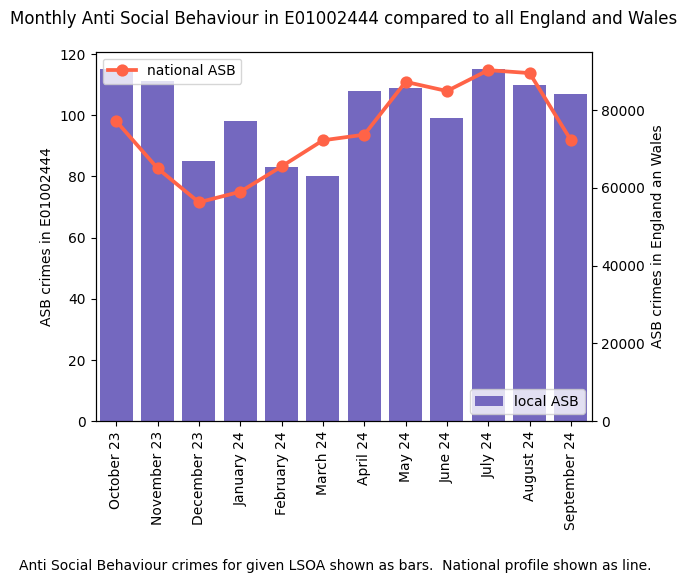

In [106]:
# define function to look at monthly pattern for any given LSOA

def lsoa_monthly_chart(lsoa):
    lsoa_asb_2324 = asb_2324[asb_2324['LSOA code'] == lsoa]
    monthly_lsoa_asb_2324 = lsoa_asb_2324['Month'].value_counts().to_frame().reset_index()
    monthly_lsoa_asb_2324['date_time'] = pd.to_datetime(monthly_lsoa_asb_2324['Month'])
    monthly_lsoa_asb_2324 = monthly_lsoa_asb_2324.sort_values(by='date_time').reset_index(drop=True)
    monthly_lsoa_asb_2324['month'] = monthly_lsoa_asb_2324['date_time'].dt.strftime("%B %y")
    monthly_lsoa_asb_2324.drop(['date_time', 'Month'], axis = 1, inplace = True)
    monthly_lsoa_asb_2324.columns = ['asb_count', 'month']
    fig, ax1 = plt.subplots()
    sns.barplot(x = 'month', y = 'asb_count', data = monthly_lsoa_asb_2324, ax=ax1, color = 'slateblue', label = 'local ASB')
    ax1.legend(loc=4)
    plt.ylabel(f"ASB crimes in {lsoa}")
    plt.xlabel("")
    plt.xticks(rotation=90)
    ax2 = ax1.twinx()
    sns.pointplot(x = 'month', y = 'asb_count', data = monthly_asb_2324, color = 'tomato', ax=ax2, label = 'national ASB')
    ax2.legend(loc=2)
    plt.ylabel("ASB crimes in England an Wales")
    plt.ylim(0,95000)
    plt.xlabel("")
    ax2.set_title(f"Monthly Anti Social Behaviour in {lsoa} compared to all England and Wales", pad=20)
    txt="Anti Social Behaviour crimes for given LSOA shown as bars.  National profile shown as line."
    plt.figtext(0.5, -0.2, txt, wrap=True, horizontalalignment='center', fontsize=10)
    plt.legend()
    plt.show()
    plt.close()

# Example
lsoa_monthly_chart("E01002444")

# Checked through the top ten and didn't find any suspicious spikes where one month is responsible for the large total.  They all appear to be genuine.
# The data files are monthly, so if there was a problem causing over-reporting it would be unlikely to give such a believeable monthly profile across 12 files

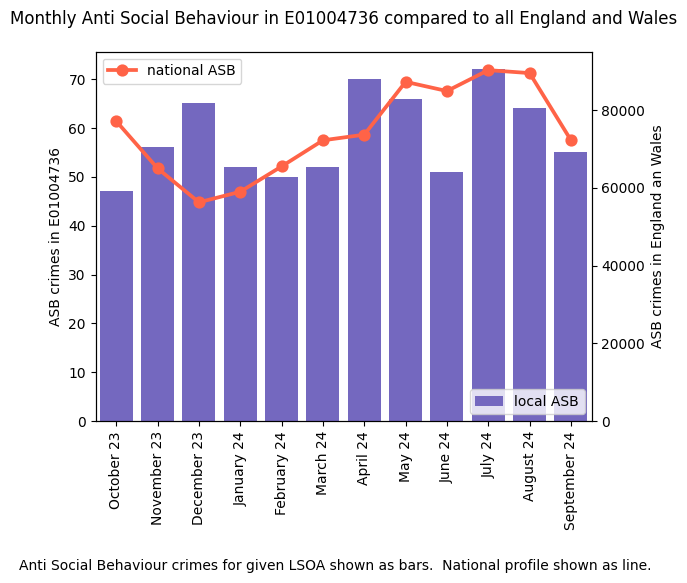

In [107]:
# Westminster one covering Pall Mall and Downing Street - could be specific political protests?
lsoa_monthly_chart("E01004736")

It looks like some areas are just ASB hotspots.</br>
It's unlikely to be about police focus, else there would be a trend towards particular regions.</br>
It's not about data collection problems, else this would be shown in the monhtly profile.</br>

Since these high figures are a real part of the data, we will not remove them as outliers. However, this means we'll need to use methods which can handle outliers and do not assume a normal distribution.

### Compare all numeric features to ASB to visualise relationships

Cycled through all features plotting linear relationships, and then with argument order = 2 to investigate possible quadratic relationships.  The only feature which seems to benefit from adding a second-degree polynomial is the lowly-educated measure.  This appeared to have no relevance when fitted with a linear regression line, and was in danger of being dropped, but will be left in the analysis.  The remaining code uses order = 2 for this feature and not for the others.

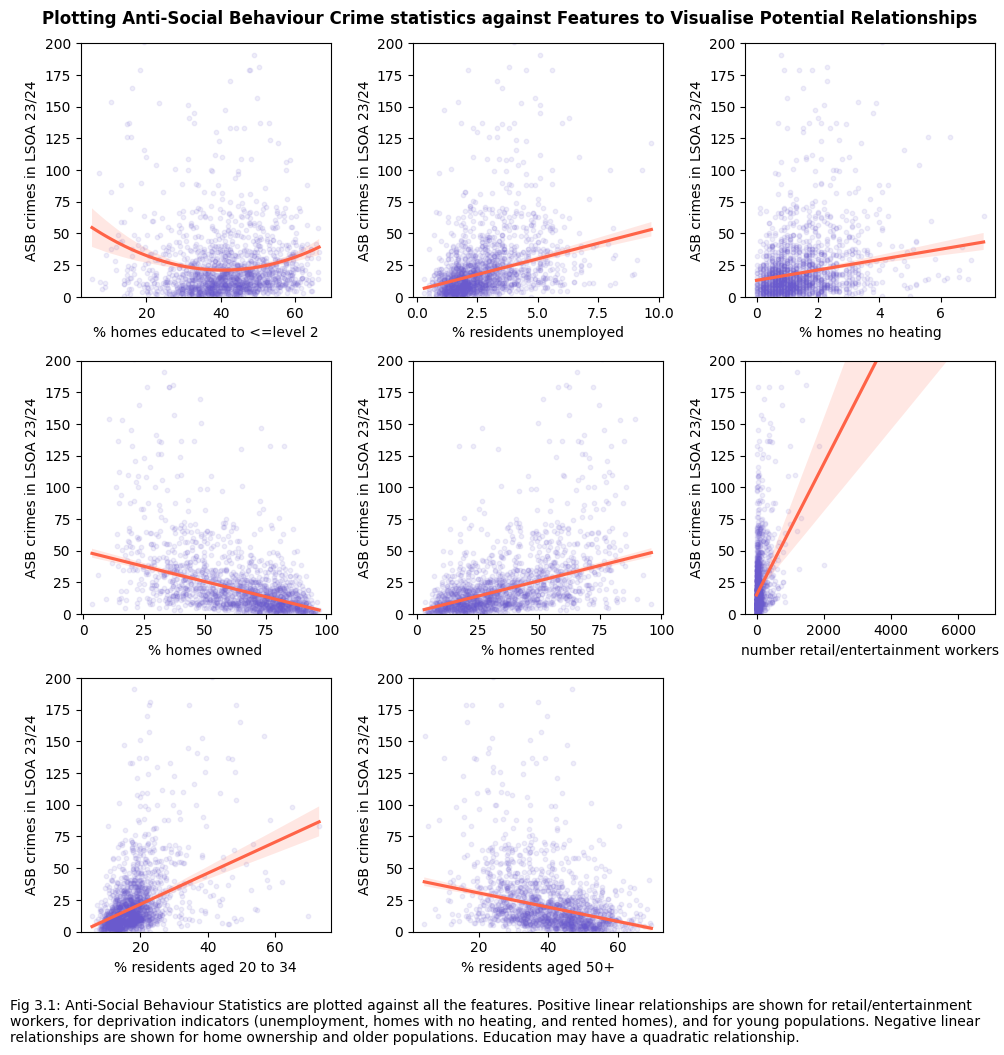

In [108]:
# make subset for plotting, due to 32,000 data points being congested even with transparency and small size
df_sample = df.sample(frac = 0.05, random_state = 355)

# numeric columns excluding target
num_cols = df_sample.select_dtypes(include=np.number).columns.tolist()[1:]

axis_labels = ['% homes educated to <=level 2',
 '% residents unemployed',
 '% homes no heating',
 '% homes owned',
 '% homes rented',
 'number retail/entertainment workers',
 '% residents aged 20 to 34',
 '% residents aged 50+']

index = 1
fig = plt.figure(figsize = (10, 10))
for col in num_cols:
    if col == "educated_level2max_perc":
        plt.subplot(3,3,index)
        ax = sns.regplot(x = df_sample[col], y = df_sample.asb_2324, 
                     scatter_kws={"color": "slateblue", 'alpha':0.1, 's': 10}, line_kws={"color": "tomato"},order = 2)
        plt.ylabel("ASB crimes in LSOA 23/24")
        plt.xlabel(axis_labels[index - 1])
        plt.ylim(0,200)
        index += 1    
    else:
        plt.subplot(3,3,index)
        ax = sns.regplot(x = df_sample[col], y = df_sample.asb_2324, 
                     scatter_kws={"color": "slateblue", 'alpha':0.1, 's': 10}, line_kws={"color": "tomato"},robust=True)
        plt.ylabel("ASB crimes in LSOA 23/24")
        plt.xlabel(axis_labels[index - 1])
        plt.ylim(0,200)
        index += 1
fig.suptitle('Plotting Anti-Social Behaviour Crime statistics against Features to Visualise Potential Relationships', fontweight='bold')
txt="Fig 3.1: Anti-Social Behaviour Statistics are plotted against all the features. \
Positive linear relationships are shown for retail/entertainment workers, for deprivation indicators (unemployment, homes with no heating, and rented homes), \
and for young populations. Negative linear relationships are shown for home ownership and older populations. \
Education may have a quadratic relationship."
plt.figtext(0, -0.05, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.tight_layout()
plt.savefig('feature_relationships.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

Looks like we have some promising features.</br>

Features which seem to be positively associated with ASB are: city centre areas (using high retail and entertainment workers as a proxy), young resident population, and signs of deprivation (a lot of rented housing, a lot of homes without heating, and high unemployment).</br>

Features which seem to be negatively associated with ASB are having a lot of home ownership and a large proportion of residents over 50 is associated with lower ASB.</br>

Level of Education seemed unrelated when shown as a linear relationship, but may have a quadratic relationship.<br>


## Modelling using Machine Learning <a id="model"></a>

### Colinearity
Some of our features are correlated.</br>
* The % of the population aged 50+ and the % of the population aged 20 to 34. If an area is populated mostly by old people it follows that there will be a corresponding lack of younger people.
* The % of homes which are rented vs owned - as one increases the other decreases

There is no need to represent the same trend in two ways, and the model may behave erratically if we include correlated values, so we'll pick one in  each case.

In [109]:
# look at correlations again
crime_corr = df.corr(numeric_only=True)['asb_2324']
crime_corr.sort_values(ascending = False)

asb_2324                        1.000000
retail_entertainment_workers    0.489288
homes_rented_perc               0.445110
age_20_34                       0.379355
unemployed_perc                 0.329319
home_no_heating_perc            0.283530
educated_level2max_perc         0.016514
age_50_plus                    -0.308562
homes_owned_perc               -0.446488
Name: asb_2324, dtype: float64

In [110]:
# will choose 'retail_entertainment_workers', 'homes_rented_perc', 'age_20_34', 'unemployed_perc', 'home_no_heating_perc', 'educated_level2max_perc'

# we've got no missing or duplicates, we've got all numerical data, we've thought about outliers, we're good to go

X = df[['retail_entertainment_workers', 'homes_rented_perc', 'age_20_34', 'unemployed_perc', 'home_no_heating_perc', 'educated_level2max_perc']]
y = df['asb_2324']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

### Finding a Benchmark

We need to know what kind of performance consitutes good.  What would a model that ignores the input features and simply estimates the average score for accuracy?

In [111]:
dummy = DummyRegressor(strategy = 'mean').fit(X_train, y_train) 
dummy_predictions = dummy.predict(X_test) 
print(f"Dummy Model achieves R squared of {dummy.score(X_test, y_test):.2f}")

Dummy Model achieves R squared of -0.00


### Training an SVM Model

A Support Vector Model should be a good choice.
* It can handle data which is non-linear
* It doesn't require normality or homoscedasticity
* It's good at handling outliers
* It's good for high-dimensional data (although we only have five features)

We have a very large dataset so it takes a long time to train.
It won't be very intepretable, but permutation importances can help.

In [120]:
# Looping to find best hyperparameters for SVR

# explore C to see how much error we ought to allow
# explore kernels in case there are non-linearities in the data
# explore gamma to test best wigglyness for decision boundary - sensitivity of model to individual data points

# hyper_cs = [0.01, 0.1, 1.0, 10, 100]
# kernels = ['linear', 'poly', 'rbf', 'sigmoid']
# gammas = [0.001, 0.01, 0.1]

# best_svr_ave_score = 0
# best_svr_c = 0
# best_svr_kernel = 'abc'
# best_svr_gamma = 0

# for gamma in gammas:
#     for c in hyper_cs:
#         for kernel in kernels:
#             svr = SVR(C = c, kernel = kernel, gamma = gamma)
#             all_scores = cross_val_score(svr, X_train_scaled, y_train, cv = 5)
#             ave_score = all_scores.mean()
#             if ave_score > best_svr_ave_score:
#                 best_all_scores = all_scores
#                 best_svr_ave_score = ave_score
#                 best_svr_c = c
#                 best_svr_kernel = kernel
#                 best_svr_gamma = gamma
#             print(kernel)
#         print(c)
#     print(gamma)

# print(best_all_scores)
# print(best_svr_ave_score)
# print(best_svr_c)
# print(best_svr_kernel)
# print(best_svr_gamma)

# Commented because it takes a couple of hours to run

linear
poly
rbf
sigmoid
0.01
linear
poly
rbf
sigmoid
0.1
linear
poly
rbf
sigmoid
1.0
linear
poly
rbf
sigmoid
10
linear
poly
rbf
sigmoid
100
0.001
linear
poly
rbf
sigmoid
0.01
linear
poly
rbf
sigmoid
0.1
linear
poly
rbf
sigmoid
1.0
linear
poly
rbf
sigmoid
10
linear
poly
rbf
sigmoid
100
0.01
linear
poly
rbf
sigmoid
0.01
linear
poly
rbf
sigmoid
0.1
linear
poly
rbf
sigmoid
1.0
linear
poly
rbf
sigmoid
10
linear
poly
rbf
sigmoid
100
0.1
[0.38352836 0.37876182 0.39904768 0.41540121 0.40830178]
0.3970081723593154
100
rbf
0.01


The model needs to beat the accuracy benchmark provided by the Dummy Model, where ignoring the input features and just predicting the mean achieved an R squared of -0.00</br>
We'll also create predictions and look at residuals to gauge accuracy.</br>

In [113]:
# using the result of the above loop to train a model
svr = SVR(C = 100, kernel = 'rbf', gamma = 0.01)
svr.fit(X_train_scaled, y_train)

print(f"test score: {svr.score(X_test_scaled, y_test):.2f}")

test score: 0.38


In [114]:
print(f"train score: {svr.score(X_train_scaled, y_train):.2f}")

train score: 0.42


In [115]:
# Using permutation importance scores to assess feature importance
# this function randomly shuffles the values of the features and observes the resulting decrease in model performance

perm_importance = permutation_importance(svr, X_test_scaled, y_test)

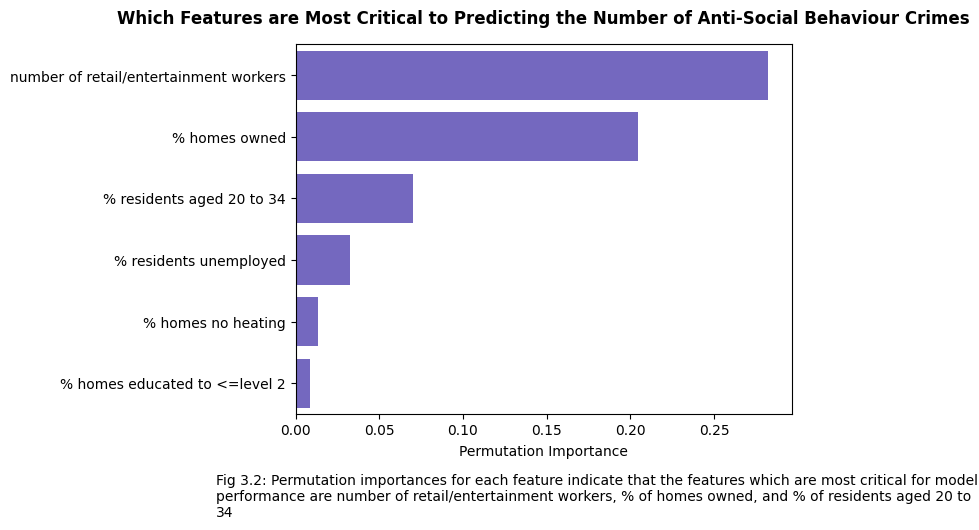

In [116]:
# plot feature importances

# order for sorting descending
sorted_indexes = np.flip(perm_importance.importances_mean.argsort())

# array of feature labels
features = np.array(['number of retail/entertainment workers', '% homes owned', '% residents aged 20 to 34', '% residents unemployed', '% homes no heating', '% homes educated to <=level 2'])

# horizontal bar plot
ax = sns.barplot(x = perm_importance.importances_mean[sorted_indexes], y = features[sorted_indexes], color="slateblue")
ax.set_title("Which Features are Most Critical to Predicting the Number of Anti-Social Behaviour Crimes", pad=15, fontweight="bold")
ax.set_xlabel("Permutation Importance", labelpad = 5)
txt="Fig 3.2: Permutation importances for each feature indicate that the features which are most critical for model performance are number of retail/entertainment workers, % of homes owned, and % of residents aged 20 to 34"
plt.figtext(0, -0.1, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.savefig('perm_importance.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()


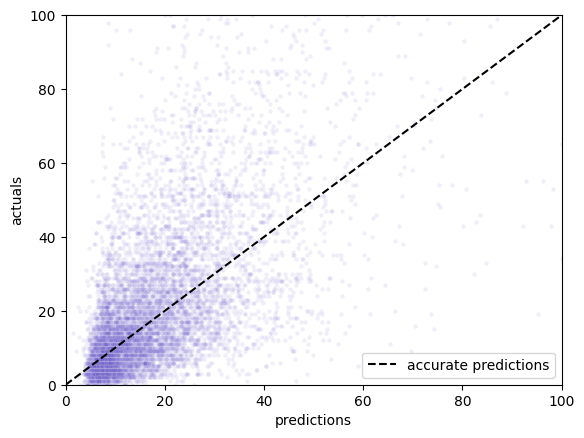

In [117]:
svr_preds = svr.predict(X_test_scaled)

svr_act_preds_df = pd.DataFrame({'predictions':svr_preds, 'actuals':y_test})
ax = sns.scatterplot(x = 'predictions', y = 'actuals', data = svr_act_preds_df, color = "slateblue", alpha = 0.1, s = 10)
ax.axline((0, 0), slope=1, color='k', ls='--', label = 'accurate predictions')
plt.xlim(0,100)
plt.ylim(0,100)
plt.legend()
plt.show()

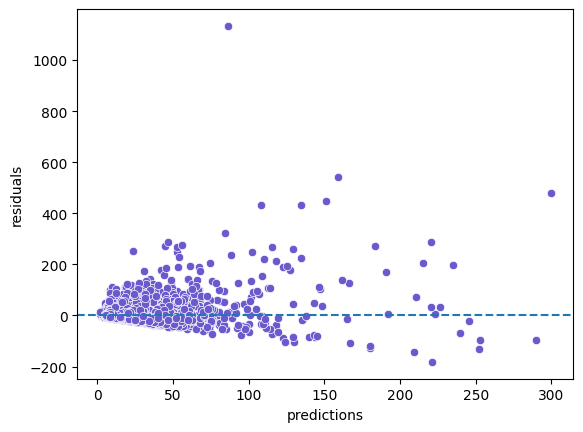

In [118]:
svr_act_preds_df['residuals'] = svr_act_preds_df['actuals'] - svr_act_preds_df['predictions']
ax = sns.scatterplot(x = 'predictions', y = 'residuals', color='slateblue', data = svr_act_preds_df)
ax.axhline(y=0, ls = '--')
plt.show()
plt.close()

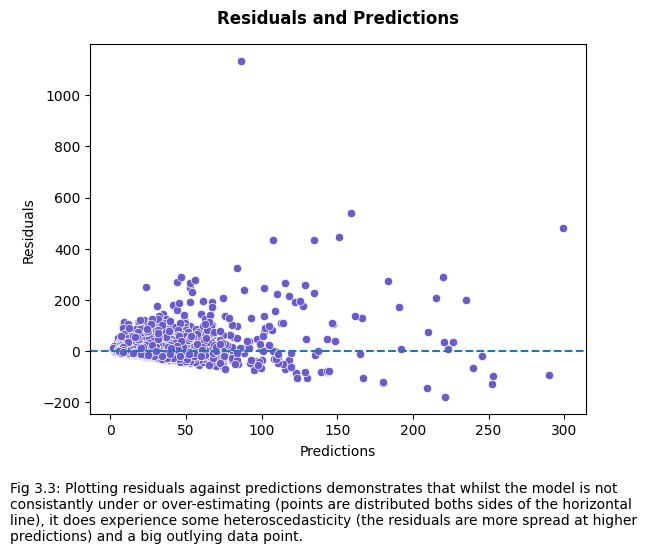

In [119]:
svr_act_preds_df['residuals'] = svr_act_preds_df['actuals'] - svr_act_preds_df['predictions']
ax = sns.scatterplot(x = 'predictions', y = 'residuals', color="slateblue", data = svr_act_preds_df)
ax.axhline(y=0, ls = '--')
ax.set_title("Residuals and Predictions", pad=15, fontweight="bold")
ax.set_xlabel("Predictions", labelpad = 5)
ax.set_ylabel("Residuals", labelpad = 5)
txt="Fig 3.3: Plotting residuals against predictions demonstrates that whilst the model is not consistantly under or over-estimating \
(points are distributed boths sides of the horizontal line), it does experience some heteroscedasticity \
(the residuals are more spread at higher predictions) and a big outlying data point."
plt.figtext(0, -0.15, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.savefig('residuals.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()
